# Big Data Application and Analytics - Project Overview <a name="1"></a>

**Google Cloud & NCAA® ML Competition 2018-Men's
Apply Machine Learning to NCAA® March Madness®
Kaggle Competition**

**Savaranan Natarajan, Senthil Palani**

The goal of our project is to predict the outcomes of college basketball games during a season based on key performance variables for each team.  There are ~5500 Men's Division 1 basketball games each year.  Our intent is to train our model on the first 80% of games played using 16 key performance variables recorded during the game by each team, and compare to the outcome of the game.  We will then predict the winners of the remaining 20% of games. 

The interesting part of this project is determining how to deal with the 'test data' for the final 20% of the games.  We can not simply use the performance variables captured during the 'test' games to predict the winner, because in reality you would not know these parameters until after the game is played (steals, shot percentage, total points,  etc.).  Instead we will have to 'predict' each teams expected game performance features based on their previous history, and then run the model using those features to create the ultimate target:  the game winner.   

We are utilizing data from a Kaggle competition based on predicting the 2018 NCAA Mens College Basketball Tourney results.  We will re-purpose the data for our study.  The key data set that we will utilize will include the 16 key performance indicators for each team during every game of the season.  This data set contains every game going back to 2003.  We will treat each season as a separate study.  Our intent is to predict the 2017-2018 season, but our stretch goal is to predict additional years and see whether the optimal method is the same or different across years.

We believe that logarithmic regressors with log loss metrics should be the first approaches to explore in order to generate a percentage chance of winning.  However, we will test many of the different methodologies studied during the course to find the best predictor.

Here's the [link](https://www.kaggle.com/c/mens-machine-learning-competition-2018#description) to the Kaggle competition 


In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




  --    safsd## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy sigmoid## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy sigmoid - Standard Scalar## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy sigmoid - Standard Scalar## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy sigm ## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy sigmoid - Standard Scalar## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy sigmoid - Standard Scalar## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy sigmoid - Standard Scalar## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy sigmoid - Standard Scalar## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy sigmoid - Standard Scalar## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy sigmoid - Standard Scalar## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy sigmoid - Standard Scalarasdasd## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy sigmoid - Standard Scalar## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy - adam optimizer - sigmoid - Standard ScalarRe-Run The Baseline Model With Data Preparation - TUNING - StandardScalerRe-Run The Baseline Model With Data Preparation - TUNING - StandardScaler  

In [0]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import os
import sys
import seaborn as sns
import time
import warnings
warnings.simplefilter('ignore')

from collections import Counter
from scipy import sparse, stats
from sklearn import preprocessing as prep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Ridge, SGDClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit, StratifiedKFold
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC, SVR
from sklearn.utils import check_array

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import log_loss, confusion_matrix
import logging

%matplotlib inline

# ETL Phase: Load and Preprocess Data

All the data can be found on Kaggle [here](https://www.kaggle.com/c/mens-machine-learning-competition-2018/data).  We used RegularSeasonDetailedResults.csv 


In [0]:
#Results = pd.read_csv(r'RegularSeasonDetailedResults.csv')
Results = pd.read_csv(r'/content/drive/My Drive/BDAA_Project/RegularSeasonDetailedResults.csv')

#Results = pd.read_csv(r'C:\Data\RegularSeasonDetailedResults.csv')

In [0]:
Results2017 = Results.loc[Results.Season == 2017]

In [0]:
HomeWin = Results2017.loc[:,['Season','DayNum','WTeamID','WScore','LTeamID','LScore','WLoc']].loc[Results.WLoc=='H']
AwayWin = Results2017.loc[:,['Season','DayNum','LTeamID','LScore','WTeamID','WScore','WLoc']].loc[Results.WLoc=='A']

HomeWin2 = pd.concat([HomeWin,Results2017.loc[:,['WFGM','WFGA','WFGM3','WFGA3','WFTM','WFTA','WOR','WDR','WAst','WTO','WStl','WBlk','WPF']].loc[Results.WLoc=='H']], axis=1)
HomeWin3 = pd.concat([HomeWin2,Results2017.loc[:,['LFGM','LFGA','LFGM3','LFGA3', 'LFTM','LFTA','LOR','LDR','LAst','LTO','LStl','LBlk','LPF']].loc[Results.WLoc=='H']], axis=1)

AwayWin2 = pd.concat([AwayWin,Results2017.loc[:,['LFGM','LFGA','LFGM3','LFGA3','LFTM','LFTA','LOR','LDR','LAst','LTO','LStl','LBlk','LPF']].loc[Results.WLoc=='A']], axis=1)
AwayWin3 = pd.concat([AwayWin2,Results2017.loc[:,['WFGM','WFGA','WFGM3','WFGA3', 'WFTM','WFTA','WOR','WDR','WAst','WTO','WStl','WBlk','WPF']].loc[Results.WLoc=='A']], axis=1)


Use train test split on neutral site games

Spliting neutral site winners between 'Home' and 'Away' with the same ratio as home team winners

In [0]:
Neut = Results2017.loc[Results.WLoc=='N']
nw, nl = train_test_split(Neut, test_size = .36, random_state = 36)
nw = nw.drop(columns=['NumOT'])
Neutral = nl.loc[:,['Season','DayNum','LTeamID','LScore','WTeamID','WScore','WLoc']]

nl2 = pd.concat([Neutral,nl.loc[:,['LFGM','LFGA','LFGM3','LFGA3', 'LFTM','LFTA','LOR','LDR','LAst','LTO','LStl','LBlk','LPF']]], axis=1)
nl3 = pd.concat([nl2,nl.loc[:,['WFGM','WFGA','WFGM3','WFGA3', 'WFTM','WFTA','WOR','WDR','WAst','WTO','WStl','WBlk','WPF']]], axis=1)
nw3 = nw

In [0]:
HomeWin3['WON'] = 1 
AwayWin3['WON'] = 0
nw3['WON'] = 1 
nl3['WON'] = 0

HomeWin3['NEUTRAL'] = 0 
AwayWin3['NEUTRAL'] = 0
nw3['NEUTRAL'] = 1 
nl3['NEUTRAL'] = 1
###############################################################################

HomeWin3.columns = ['Season','DayNum','HTeamID','HScore','ATeamID','AScore','WLoc','HFGM','HFGA','HFGM3','HFGA3','HFTM','HFTA','HOR','HDR','HAst','HTO','HStl','HBlk','HPF','AFGM','AFGA','AFGM3','AFGA3','AFTM','AFTA','AOR','ADR','AAst','ATO','AStl','ABlk','APF','WON','NEUTRAL']
AwayWin3.columns = ['Season','DayNum','HTeamID','HScore','ATeamID','AScore','WLoc','HFGM','HFGA','HFGM3','HFGA3','HFTM','HFTA','HOR','HDR','HAst','HTO','HStl','HBlk','HPF','AFGM','AFGA','AFGM3','AFGA3','AFTM','AFTA','AOR','ADR','AAst','ATO','AStl','ABlk','APF','WON','NEUTRAL']
nw3.columns = ['Season','DayNum','HTeamID','HScore','ATeamID','AScore','WLoc','HFGM','HFGA','HFGM3','HFGA3','HFTM','HFTA','HOR','HDR','HAst','HTO','HStl','HBlk','HPF','AFGM','AFGA','AFGM3','AFGA3','AFTM','AFTA','AOR','ADR','AAst','ATO','AStl','ABlk','APF','WON','NEUTRAL']
nl3.columns = ['Season','DayNum','HTeamID','HScore','ATeamID','AScore','WLoc','HFGM','HFGA','HFGM3','HFGA3','HFTM','HFTA','HOR','HDR','HAst','HTO','HStl','HBlk','HPF','AFGM','AFGA','AFGM3','AFGA3','AFTM','AFTA','AOR','ADR','AAst','ATO','AStl','ABlk','APF','WON','NEUTRAL']

HomeAwayResults = pd.concat([HomeWin3,AwayWin3,nw3,nl3])

Notebook Cleanup - deleting old/temporary variables

In [0]:
del AwayWin
del AwayWin2
del AwayWin3
del HomeWin
del HomeWin2
del HomeWin3
del Neutral
del Neut
del nl
del nl2
del nl3
del nw
del nw3

# Exploritory Data Analysis

In [0]:
HomeAwayResults.head()

,Season,DayNum,HTeamID,HScore,ATeamID,AScore,WLoc,HFGM,HFGA,HFGM3,HFGA3,HFTM,HFTA,HOR,HDR,HAst,HTO,HStl,HBlk,HPF,AFGM,AFGA,AFGM3,AFGA3,AFTM,AFTA,AOR,ADR,AAst,ATO,AStl,ABlk,APF,WON,NEUTRAL
71241,2017,11,1104,70,1157,53,H,21,48,10,26,18,26,7,32,13,11,8,8,19,17,62,9,23,10,16,17,26,7,13,2,2,22,1,0
71244,2017,11,1113,88,1340,70,H,33,67,9,28,13,18,12,35,11,16,7,3,15,26,67,6,27,12,15,9,24,14,14,5,1,20,1,0
71245,2017,11,1116,92,1236,83,H,35,66,6,16,16,24,10,29,20,13,9,9,29,25,69,9,28,24,40,21,24,12,12,5,2,24,1,0
71246,2017,11,1120,83,1316,66,H,25,60,13,32,20,31,11,25,17,17,11,6,21,22,57,6,20,16,24,14,28,10,28,2,2,30,1,0
71248,2017,11,1124,76,1331,61,H,24,54,10,26,18,26,10,26,18,11,9,5,18,24,58,3,13,10,14,9,24,13,14,3,0,19,1,0


In [0]:
Results2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5395 entries, 71241 to 76635
Data columns (total 34 columns):
Season     5395 non-null int64
DayNum     5395 non-null int64
WTeamID    5395 non-null int64
WScore     5395 non-null int64
LTeamID    5395 non-null int64
LScore     5395 non-null int64
WLoc       5395 non-null object
NumOT      5395 non-null int64
WFGM       5395 non-null int64
WFGA       5395 non-null int64
WFGM3      5395 non-null int64
WFGA3      5395 non-null int64
WFTM       5395 non-null int64
WFTA       5395 non-null int64
WOR        5395 non-null int64
WDR        5395 non-null int64
WAst       5395 non-null int64
WTO        5395 non-null int64
WStl       5395 non-null int64
WBlk       5395 non-null int64
WPF        5395 non-null int64
LFGM       5395 non-null int64
LFGA       5395 non-null int64
LFGM3      5395 non-null int64
LFGA3      5395 non-null int64
LFTM       5395 non-null int64
LFTA       5395 non-null int64
LOR        5395 non-null int64
LDR        5395 non

In [0]:
Results2017.describe()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
count,5395.0,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000,5395.000000
mean,2017.0,70.796849,1288.622428,78.645783,1280.339203,66.615199,0.075626,27.227618,57.113994,8.011307,20.687488,16.179240,22.509361,10.232437,27.105097,14.988137,12.433920,6.565153,3.868582,17.891381,23.655422,58.328082,6.688230,21.288415,12.616126,18.404263,10.497683,22.932901,11.660426,13.611863,5.628360,2.868026,19.956256
std,0.0,35.602035,104.357877,11.084819,103.430881,11.062746,0.323113,4.651649,7.118689,3.197153,5.831637,6.266982,8.029588,3.919720,4.944846,4.461080,3.745995,2.955041,2.387313,4.148664,4.374023,7.418264,2.840188,6.037966,5.443477,7.147102,4.075454,4.482068,3.699500,4.053207,2.623722,1.969363,4.575484
min,2017.0,11.000000,1101.000000,43.000000,1101.000000,27.000000,0.000000,12.000000,36.000000,0.000000,3.000000,0.000000,0.000000,0.000000,13.000000,3.000000,2.000000,0.000000,0.000000,5.000000,9.000000,36.000000,0.000000,1.000000,0.000000,0.000000,1.000000,8.000000,2.000000,1.000000,0.000000,0.000000,6.000000
25%,2017.0,37.000000,1201.500000,71.000000,1188.000000,59.000000,0.000000,24.000000,52.000000,6.000000,17.000000,12.000000,17.000000,7.000000,24.000000,12.000000,10.000000,4.000000,2.000000,15.000000,21.000000,53.000000,5.000000,17.000000,9.000000,13.000000,8.000000,20.000000,9.000000,11.000000,4.000000,1.000000,17.000000
50%,2017.0,73.000000,1288.000000,78.000000,1280.000000,66.000000,0.000000,27.000000,57.000000,8.000000,20.000000,16.000000,22.000000,10.000000,27.000000,15.000000,12.000000,6.000000,4.000000,18.000000,24.000000,58.000000,6.000000,21.000000,12.000000,18.000000,10.000000,23.000000,11.000000,13.000000,5.000000,3.000000,20.000000
75%,2017.0,102.000000,1380.000000,85.000000,1369.000000,74.000000,0.000000,30.000000,62.000000,10.000000,24.000000,20.000000,28.000000,13.000000,30.000000,18.000000,15.000000,8.000000,5.000000,20.000000,27.000000,63.000000,8.000000,25.000000,16.000000,23.000000,13.000000,26.000000,14.000000,16.000000,7.000000,4.000000,23.000000
max,2017.0,132.000000,1464.000000,131.000000,1464.000000,127.000000,4.000000,54.000000,92.000000,22.000000,53.000000,45.000000,56.000000,28.000000,51.000000,36.000000,28.000000,21.000000,18.000000,36.000000,45.000000,104.000000,19.000000,58.000000,37.000000,54.000000,34.000000,49.000000,30.000000,40.000000,19.000000,15.000000,38.000000


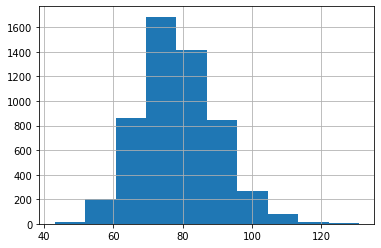

In [0]:
Results2017['WScore'].hist()

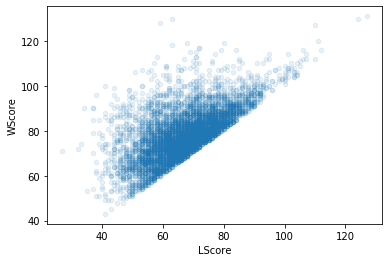

In [0]:
Results2017.plot(kind="scatter", x="LScore", y="WScore", alpha=0.1)

In [0]:
Results2017['WLoc'].value_counts()

H    3093
A    1704
N     598
Name: WLoc, dtype: int64

In [0]:
#Average Margin of victory
(Results2017['WScore']-Results2017['LScore']).mean()

12.030583873957369

In [0]:
# Average Turnover Differential
(Results2017['LTO']-Results2017['WTO']).mean()

1.1779425393883225

In [0]:
# Average 3 Pointer Made Differential
(Results2017['WFGM3']-Results2017['LFGM3']).mean()

1.323076923076923

In [0]:
# Average Assist Differential
(Results2017['WAst']-Results2017['LAst']).mean()

3.327710843373494

In [0]:
# Average Free Throw Attempted Differential
(Results2017['WFTA']-Results2017['LFTA']).mean()

4.105097312326228

Per Season statistics on game location, home/away winner, and what day of the season 80% of games were completed

In [0]:
SeasonStats = Results['Season'].value_counts()
SeasonStats = SeasonStats.rename('NumGames')

SeasonStats = pd.concat([SeasonStats,Results['Season'].loc[Results.WLoc == 'N'].value_counts()],axis=1)
SeasonStats = SeasonStats.rename(columns={'Season':'NeutralSiteGames'})

SeasonStats = pd.concat([SeasonStats,Results['Season'].loc[Results.WLoc != 'N'].value_counts()],axis=1)
SeasonStats = SeasonStats.rename(columns={'Season':'NonNeutralGames'})

SeasonStats = pd.concat([SeasonStats,Results['Season'].loc[Results.WLoc == 'H'].value_counts()],axis=1)
SeasonStats = SeasonStats.rename(columns={'Season':'HomeWins'})

SeasonStats = pd.concat([SeasonStats,Results['Season'].loc[Results.WLoc == 'A'].value_counts()],axis=1)
SeasonStats = SeasonStats.rename(columns={'Season':'AwayWins'})


SeasonStats['HomeLosePct'] = np.round((SeasonStats.AwayWins / SeasonStats.NonNeutralGames),2)

SeasonStats['DayNum80'] = 0


for s in SeasonStats.index:
    x = Results['DayNum'].loc[Results.Season == s]
    SeasonStats['DayNum80'].loc[s] = x.iloc[round(len(x)*.8)]

In [0]:
SeasonStats

,NumGames,NeutralSiteGames,NonNeutralGames,HomeWins,AwayWins,HomeLosePct,DayNum80
2003,4616,418,4198,2812,1386,0.33,108
2004,4571,415,4156,2749,1407,0.34,108
2005,4675,439,4236,2849,1387,0.33,108
2006,4757,441,4316,2866,1450,0.34,108
2007,5043,504,4539,3066,1473,0.32,107
2008,5163,505,4658,3093,1565,0.34,106
2009,5249,521,4728,3139,1589,0.34,107
2010,5263,530,4733,3128,1605,0.34,107
2011,5246,546,4700,3102,1598,0.34,107
2012,5253,520,4733,3119,1614,0.34,107


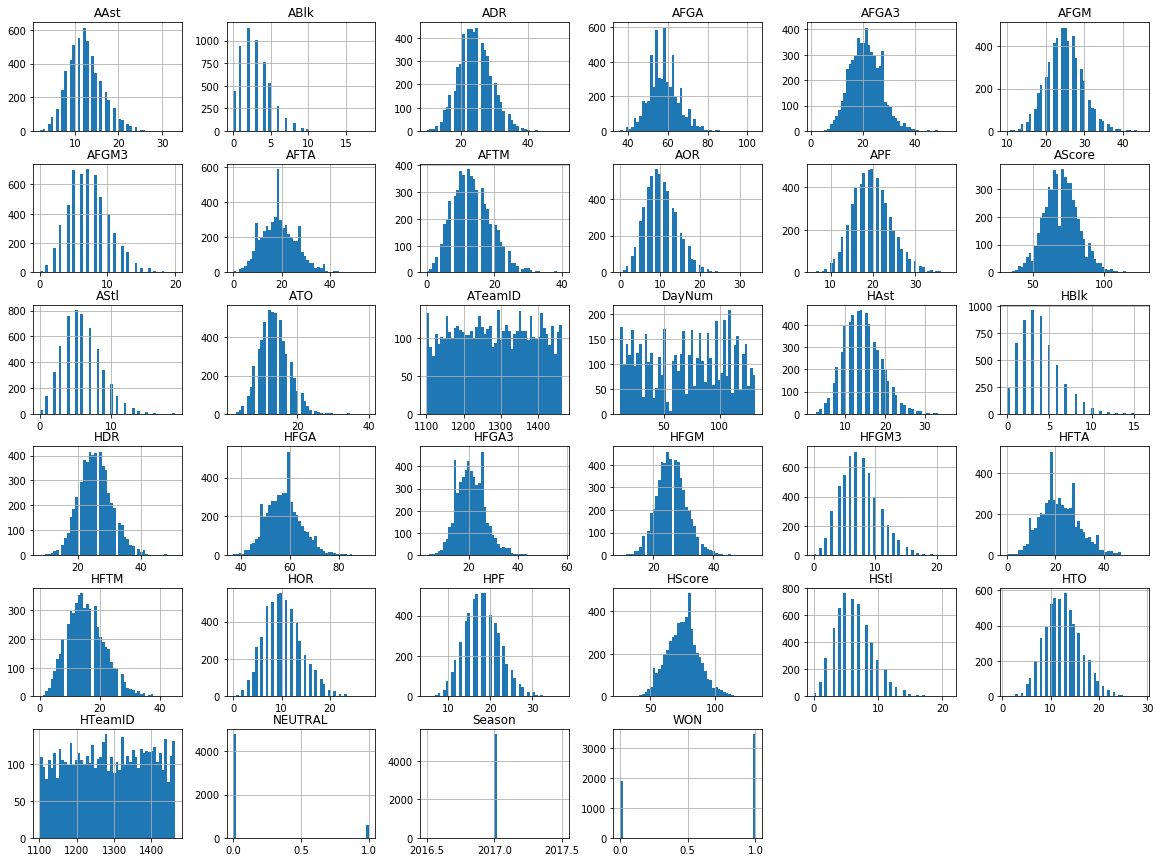

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
HomeAwayResults.hist(bins=50, figsize=(20,15))
plt.show()

# Feature Engineering

First we removed the team performance variables that directly impact the result of the game.  Any of the fields
That indicated points scored was removed.  Instead we created new fields that showed the shooting percentage.
Shooting percentage is indicative of performance without giving a 1-to-1 ratio to winning.
 
After completing many logistic regressions runs using Lasso and Ridge, we evaluated the most impactful coefficients
We fount that 3-point shooting, defensive rebounds and turnovers seemed to always be the most important.
To capitalize on this, we created many new features that compared the ratio of these variables between the two
competing teams.  In our initial runs, we found that these variables increased the overall accuracy of the model by 5%
This looks like a good area to look at in future runs.

In [0]:
###############################################################################

HomeAwayResults['HFGM2']=HomeAwayResults['HFGM'] - HomeAwayResults['HFGM3'] #HOME 2 POINT FIELD GOALS MADE
HomeAwayResults['AFGM2']=HomeAwayResults['AFGM'] - HomeAwayResults['AFGM3'] #AWAY 2 POINT FILED GOALS MADE
HomeAwayResults['HFGA2']=HomeAwayResults['HFGA'] - HomeAwayResults['HFGA3'] #HOME 2 POINT FIELD GOALS ATTEMPTED
HomeAwayResults['AFGA2']=HomeAwayResults['AFGA'] - HomeAwayResults['AFGA3'] #AWAY 2 POINT FIELD GOALS ATTEMPTED

HomeAwayResults['HFGP']=HomeAwayResults['HFGM'] / HomeAwayResults['HFGA'] #HOME FIELD GOALS PERCENTAGE MADE - ALL
HomeAwayResults['AFGP']=HomeAwayResults['AFGM'] / HomeAwayResults['AFGA'] #AWAY FIELD GOALS PERCENTAGE MADE - ALL
HomeAwayResults['HFGP2']=HomeAwayResults['HFGM2'] / HomeAwayResults['HFGA2'] #HOME FIELD GOALS PERCENTAGE MADE - 2 PT
HomeAwayResults['AFGP2']=HomeAwayResults['AFGM2'] / HomeAwayResults['AFGA2'] #AWAY FIELD GOALS PERCENTAGE MADE - 2 PT
HomeAwayResults['HFGP3']=HomeAwayResults['HFGM3'] / HomeAwayResults['HFGA3'] #HOME FIELD GOALS PERCENTAGE MADE - 3 PT
HomeAwayResults['AFGP3']=HomeAwayResults['AFGM3'] / HomeAwayResults['AFGA3'] #AWAY FIELD GOALS PERCENTAGE MADE - 3 PT
###############################################################################
# Features created in Phase 1
HomeAwayResults['HTORC']=HomeAwayResults['HTO'] / HomeAwayResults['ATO'] #HOME TURNOVER RATIO VS COMPETITOR 
HomeAwayResults['ATORC']=HomeAwayResults['ATO'] / HomeAwayResults['HTO'] #AWAY TURNOVER RATIO VS COMPETITOR
HomeAwayResults['HDRR']=HomeAwayResults['HDR'] / HomeAwayResults['ADR'] #HOME DEFENSIVE REBOUND RATION VS COMPETITOR
HomeAwayResults['ADRR']=HomeAwayResults['ADR'] / HomeAwayResults['HDR'] #AWAY DEFENSIVE REBOUND RATION VS COMPETITOR
HomeAwayResults['APFR']=HomeAwayResults['APF'] / HomeAwayResults['HPF'] #AWAY PERSONAL FOUL RATIO VS COMPETITOR
HomeAwayResults['HPFR']=HomeAwayResults['HPF'] / HomeAwayResults['APF'] #HOME PERSONAL FOUL RATIO VS COMPETITOR
HomeAwayResults['ATODR']=HomeAwayResults['ATO'] + HomeAwayResults['HDR'] #AWAY TEAM LOST POSSESSIONS: TURNOVERS + COMPETITORS DEF REBOUNDS
HomeAwayResults['HTODR']=HomeAwayResults['HTO'] + HomeAwayResults['ADR'] #HOME TEAM LOST POSSESSIONS: TURNOVERS + COMPETITORS DEF REBOUNDS
HomeAwayResults['ATODRR']=HomeAwayResults['ATODR'] / HomeAwayResults['HTODR'] #HOME TEAM LOST POSSESSIONS RATIO
HomeAwayResults['HTODRR']=HomeAwayResults['HTODR'] / HomeAwayResults['ATODR'] #AWAY TEAM LOST POSSESSIONS: RATIO
HomeAwayResults['H3VTO']=HomeAwayResults['HFGP3'] / HomeAwayResults['HTODRR'] #HOME 3PTS OVERCOMING TURNOVER RATIO
HomeAwayResults['A3VTO']=HomeAwayResults['AFGP3'] / HomeAwayResults['ATODRR'] #AWAY 3PTS OVERCOMING TURNOVER RATIO


In [0]:
###############################################################################
# New Features Phase 2
###############################################################################
# Number of Possessions
HomeAwayResults['HPoss']= (HomeAwayResults['HFGA'] - HomeAwayResults['HOR'] + HomeAwayResults['HTO'] + (0.44 * HomeAwayResults['HFTA'])) # HOME Number of Possessions
HomeAwayResults['APoss']= (HomeAwayResults['AFGA'] - HomeAwayResults['AOR'] + HomeAwayResults['ATO'] + (0.44 * HomeAwayResults['AFTA'])) # AWAY Number of Possessions

# "Four Factors"
HomeAwayResults['HeFGP'] = ((HomeAwayResults['HFGM'] + (0.5*HomeAwayResults['HFGM3'])) / HomeAwayResults['HFGA']) # HOME Effective Field Goal Perc (0.4)
HomeAwayResults['AeFGP'] = ((HomeAwayResults['AFGM'] + (0.5*HomeAwayResults['AFGM3'])) / HomeAwayResults['AFGA']) # AWAY Effective Field Goal Perc (0.4)

HomeAwayResults['HTOR'] = (HomeAwayResults['HTO'] / HomeAwayResults['HPoss']) # HOME Turnover Perc (0.25)
HomeAwayResults['ATOR'] = (HomeAwayResults['ATO'] / HomeAwayResults['APoss']) # AWAY Turnover Perc (0.25)

HomeAwayResults['HORR'] = HomeAwayResults['HOR'] / (HomeAwayResults['HOR'] + HomeAwayResults['ADR']) #HOME Off Rebound Rate (0.2)
HomeAwayResults['AORR'] = HomeAwayResults['AOR'] / (HomeAwayResults['AOR'] + HomeAwayResults['HDR']) #AWAY Off Rebound Rate (0.2)

HomeAwayResults['HFTR'] = (HomeAwayResults['HFTA'] / HomeAwayResults['HFGA']) # HOME Free Throw Rate (0.15)
HomeAwayResults['AFTR'] = (HomeAwayResults['AFTA'] / HomeAwayResults['AFGA']) # AWAY Free Throw Rate (0.15)

# Off and Def Efficiency
HomeAwayResults['HOffEf'] = ((HomeAwayResults['HScore']*100) / HomeAwayResults['HPoss']) # HOME Offensive Efficiency
HomeAwayResults['AOffEf'] = ((HomeAwayResults['AScore']*100) / HomeAwayResults['APoss']) # AWAY Offensive Efficiency

HomeAwayResults['HDefEf'] = ((HomeAwayResults['AScore']*100) / HomeAwayResults['APoss']) # HOME Defensive Efficiency
HomeAwayResults['ADefEf'] = ((HomeAwayResults['HScore']*100) / HomeAwayResults['HPoss']) # HOME Defensive Efficiency


###############################################################################

# Data Prep

Because our problem resembles a time series analysis problem, we won't create a random 80/20 split
of our dataset using train_test_split, or any similar function. 
Our training set will be the first 80 percent of games in the season, and our test set will be final 
20 percent of games. 
We aren't using the actual game statistics for those games in the test set, but rather each team's 
home and away averages from the first 80 percent of games, thus simulating predicting the outcome 
of the game before the game starts.

In [0]:
def completeAverages():
    TeamAvgH['HFGM2']=TeamSumH['HFGM'] - TeamSumH['HFGM3'] #HOME 2 POINT FIELD GOALS MADE
    TeamAvgA['AFGM2']=TeamSumA['AFGM'] - TeamSumA['AFGM3'] #AWAY 2 POINT FILED GOALS MADE
    TeamAvgH['HFGA2']=TeamSumH['HFGA'] - TeamSumH['HFGA3'] #HOME 2 POINT FIELD GOALS ATTEMPTED
    TeamAvgA['AFGA2']=TeamSumA['AFGA'] - TeamSumA['AFGA3'] #AWAY 2 POINT FIELD GOALS ATTEMPTED

    TeamAvgH['HFGP']=TeamSumH['HFGM'] / TeamSumH['HFGA'] #HOME FIELD GOALS PERCENTAGE MADE - ALL
    TeamAvgA['AFGP']=TeamSumA['AFGM'] / TeamSumA['AFGA'] #AWAY FIELD GOALS PERCENTAGE MADE - ALL
    TeamAvgH['HFGP2']=TeamSumH['HFGM2'] / TeamSumH['HFGA2'] #HOME FIELD GOALS PERCENTAGE MADE - 2 PT
    TeamAvgA['AFGP2']=TeamSumA['AFGM2'] / TeamSumA['AFGA2'] #AWAY FIELD GOALS PERCENTAGE MADE - 2 PT
    TeamAvgH['HFGP3']=TeamSumH['HFGM3'] / TeamSumH['HFGA3'] #HOME FIELD GOALS PERCENTAGE MADE - 3 PT
    TeamAvgA['AFGP3']=TeamSumA['AFGM3'] / TeamSumA['AFGA3'] #AWAY FIELD GOALS PERCENTAGE MADE - 3 PT
# Features created in Phase 1
    TeamAvgH['HTORC']=TeamSumH['HTO'] / TeamSumA['ATO'] #HOME TURNOVER RATIO VS COMPETITOR 
    TeamAvgA['ATORC']=TeamSumA['ATO'] / TeamSumH['HTO'] #AWAY TURNOVER RATIO VS COMPETITOR
    TeamAvgH['HDRR']=TeamSumH['HDR'] / TeamSumA['ADR'] #HOME DEFENSIVE REBOUND RATION VS COMPETITOR
    TeamAvgA['ADRR']=TeamSumA['ADR'] / TeamSumH['HDR'] #AWAY DEFENSIVE REBOUND RATION VS COMPETITOR
    TeamAvgH['HPFR']=TeamSumH['HPF'] / TeamSumA['APF'] #HOME PERSONAL FOUL RATIO VS COMPETITOR
    TeamAvgA['APFR']=TeamSumA['APF'] / TeamSumH['HPF'] #AWAY PERSONAL FOUL RATIO VS COMPETITOR
    TeamAvgH['HTODR']=TeamSumH['HTO'] + TeamSumA['ADR'] #HOME TEAM LOST POSSESSIONS: TURNOVERS + COMPETITORS DEF REBOUNDS
    TeamAvgA['ATODR']=TeamSumA['ATO'] + TeamSumH['HDR'] #AWAY TEAM LOST POSSESSIONS: TURNOVERS + COMPETITORS DEF REBOUNDS
    TeamAvgH['HTODRR']=TeamSumH['HTODR'] / TeamSumA['ATODR'] #HOME TEAM LOST POSSESSIONS RATIO
    TeamAvgA['ATODRR']=TeamSumA['ATODR'] / TeamSumH['HTODR'] #AWAY TEAM LOST POSSESSIONS: RATIO
    TeamAvgH['H3VTO']=TeamSumH['HFGP3'] / TeamSumH['HTODRR'] #HOME 3PTS OVERCOMING TURNOVER RATIO
    TeamAvgA['A3VTO']=TeamSumA['AFGP3'] / TeamSumA['ATODRR'] #AWAY 3PTS OVERCOMING TURNOVER RATIO
# New Features Phase 2

    TeamAvgH['HPoss']= (TeamSumH['HFGA'] - TeamSumH['HOR'] + TeamSumH['HTO'] + (0.44 * TeamSumH['HFTA'])) # HOME Number of Possessions
    TeamAvgA['APoss']= (TeamSumA['AFGA'] - TeamSumA['AOR'] + TeamSumA['ATO'] + (0.44 * TeamSumA['AFTA'])) # AWAY Number of Possessions

# "Four Factors"
    TeamAvgH['HeFGP'] = ((TeamSumH['HFGM'] + (0.5*TeamSumH['HFGM3'])) / TeamSumH['HFGA']) # HOME Effective Field Goal Perc (0.4)
    TeamAvgA['AeFGP'] = ((TeamSumA['AFGM'] + (0.5*TeamSumA['AFGM3'])) / TeamSumA['AFGA']) # AWAY Effective Field Goal Perc (0.4)
    
    TeamAvgH['HTOR'] = (TeamSumH['HTO'] / TeamSumH['HPoss']) # HOME Turnover Perc (0.25)
    TeamAvgA['ATOR'] = (TeamSumA['ATO'] / TeamSumA['APoss']) # AWAY Turnover Perc (0.25)
    
    TeamAvgH['HORR'] = TeamSumH['HOR'] / (TeamSumH['HOR'] + TeamSumH['ADR']) #HOME Off Rebound Rate (0.2)
    TeamAvgA['AORR'] = TeamSumA['AOR'] / (TeamSumA['AOR'] + TeamSumA['HDR']) #AWAY Off Rebound Rate (0.2)

    TeamAvgH['HFTR'] = (TeamSumH['HFTA'] / TeamSumH['HFGA']) # HOME Free Throw Rate (0.15)
    TeamAvgA['AFTR'] = (TeamSumA['AFTA'] / TeamSumA['AFGA']) # AWAY Free Throw Rate (0.15)

# Off and Def Efficiency
    TeamAvgH['HOffEf'] = ((TeamSumH['HScore']*100) / TeamSumH['HPoss']) # HOME Offensive Efficiency
    TeamAvgA['AOffEf'] = ((TeamSumA['AScore']*100) / TeamSumA['APoss']) # AWAY Offensive Efficiency
    
    TeamAvgH['HDefEf'] = ((TeamSumH['AScore']*100) / TeamSumH['APoss']) # HOME Defensive Efficiency
    TeamAvgA['ADefEf'] = ((TeamSumA['HScore']*100) / TeamSumA['HPoss']) # HOME Defensive Efficiency

def calcDifferences(df):
    df['eFGP'] = df['HeFGP'] - df['AeFGP']
    df['TOR'] = df['HTOR'] - df['ATOR']
    df['ORR'] = df['HORR'] - df['AORR']
    df['FTR'] = df['HFTR'] - df['AFTR']
    df['OffEf'] = df['HOffEf'] - df['AOffEf']
    df['DefEf'] = df['HDefEf'] - df['ADefEf']

def reduceFeat(df):
    df2 = df.loc[:,['HTeamID','ATeamID','NEUTRAL','eFGP','TOR','ORR','FTR','OffEf','DefEf']]
    return df2
       

In [0]:
X80=HomeAwayResults.loc[HomeAwayResults.DayNum<107]
X20=HomeAwayResults.loc[HomeAwayResults.DayNum>=107]

y_train = X80["WON"]
y_test = X20["WON"]

In [0]:
# Total team averages
X20H = X80[['HTeamID','HScore','HFGM', 'HFGA', 'HFGM3', 'HFGA3', 'HFTM', 'HFTA', 'HOR', 'HDR', 'HAst',
       'HTO', 'HStl', 'HBlk', 'HPF', 'HFGM2', 'HFGA2', 'HFGP', 'HFGP2', 'HFGP3', 
       'HTORC','HDRR','HPFR','HTODR','HTODRR','H3VTO', 'HPoss', 
       'HeFGP', 'HTOR', 'HORR', 'HFTR', 'HOffEf', 'HDefEf','AScore','ADR','APoss']]

X20A = X80[['ATeamID','AScore','AFGM', 'AFGA', 'AFGM3', 'AFGA3', 'AFTM', 'AFTA', 'AOR', 'ADR', 'AAst',
       'ATO', 'AStl', 'ABlk', 'APF', 'AFGM2', 'AFGA2', 'AFGP', 'AFGP2', 'AFGP3', 
       'ATORC','ADRR','APFR','ATODR','ATODRR','A3VTO', 'APoss', 
       'AeFGP', 'ATOR', 'AORR', 'AFTR', 'AOffEf', 'ADefEf','HScore','HDR','HPoss']]


In [0]:
AllStatsA = X20H.copy()
AllStatsA.columns = X20A.columns
AllStatsA = AllStatsA.append(X20A)

AllStatsH = X20A.copy()
AllStatsH.columns = X20H.columns
AllStatsH = AllStatsH.append(X20H)


TeamAvgA = AllStatsA.groupby(['ATeamID']).mean()
TeamAvgH = AllStatsH.groupby(['HTeamID']).mean()

TeamSumA = AllStatsA.groupby(['ATeamID']).sum()
TeamSumH = AllStatsH.groupby(['HTeamID']).sum()

#            ------------- FILL OUT AVERAGES! ----------
completeAverages()

TotAvgH = TeamAvgH.drop(['HScore','AScore','ADR','APoss'], axis=1)
TotAvgA = TeamAvgA.drop(['AScore','HScore','HDR','HPoss'], axis=1)

In [0]:
# FOR TRAIN 
XAHtrain = pd.DataFrame(X80[['HTeamID','ATeamID','NEUTRAL']])
XTempA = pd.merge(XAHtrain,TotAvgH, on=['HTeamID'], right_index=True, left_index=False)
XTempB = pd.merge(XTempA,TotAvgA, on=['ATeamID'], right_index=True, left_index=False)
X_trainAllAvg = XTempB

# FOR TEST
XAH = pd.DataFrame(X20[['HTeamID','ATeamID','NEUTRAL']])
XTempA = pd.merge(XAH,TotAvgH, on=['HTeamID'], right_index=True, left_index=False)
XTempB = pd.merge(XTempA,TotAvgA, on=['ATeamID'], right_index=True, left_index=False)
X_testAllAvg = XTempB

In [0]:
TeamAvgH = X20H.groupby(['HTeamID']).mean()
TeamAvgA = X20A.groupby(['ATeamID']).mean()

TeamSumH = X20H.groupby(['HTeamID']).sum()
TeamSumA = X20A.groupby(['ATeamID']).sum()

#            ------------- FILL OUT AVERAGES! ----------
completeAverages()


HomeAvg = TeamAvgH.drop(['HScore','AScore','ADR','APoss'], axis=1)
AwayAvg = TeamAvgA.drop(['AScore','HScore','HDR','HPoss'], axis=1)

In [0]:
# FOR TRAIN 
XAHtrain = pd.DataFrame(X80[['HTeamID','ATeamID','NEUTRAL']])
XTempA = pd.merge(XAHtrain,HomeAvg, on=['HTeamID'], right_index=True, left_index=False)
X_trainHAAvg = XTempB

# FOR TEST
XAH = pd.DataFrame(X20[['HTeamID','ATeamID','NEUTRAL']])
XTempA = pd.merge(XAH,HomeAvg, on=['HTeamID'], right_index=True, left_index=False)
XTempB = pd.merge(XTempA,AwayAvg, on=['ATeamID'], right_index=True, left_index=False)
X_testHAAvg = XTempB

In [0]:
X_train = X_trainAllAvg.drop(['HTeamID','ATeamID'], axis =1)
X_test = X_testAllAvg.drop(['HTeamID','ATeamID'], axis =1)

Notebook Cleanup - deleting old/temporary variables

# Feature Selection

## Feature Correlation Plot

In [0]:
X_train_corr_plot = X_train.drop(['HTORC','ATORC','HDRR','ADRR','HPFR','APFR','HTODRR','ATODRR'],axis=1)

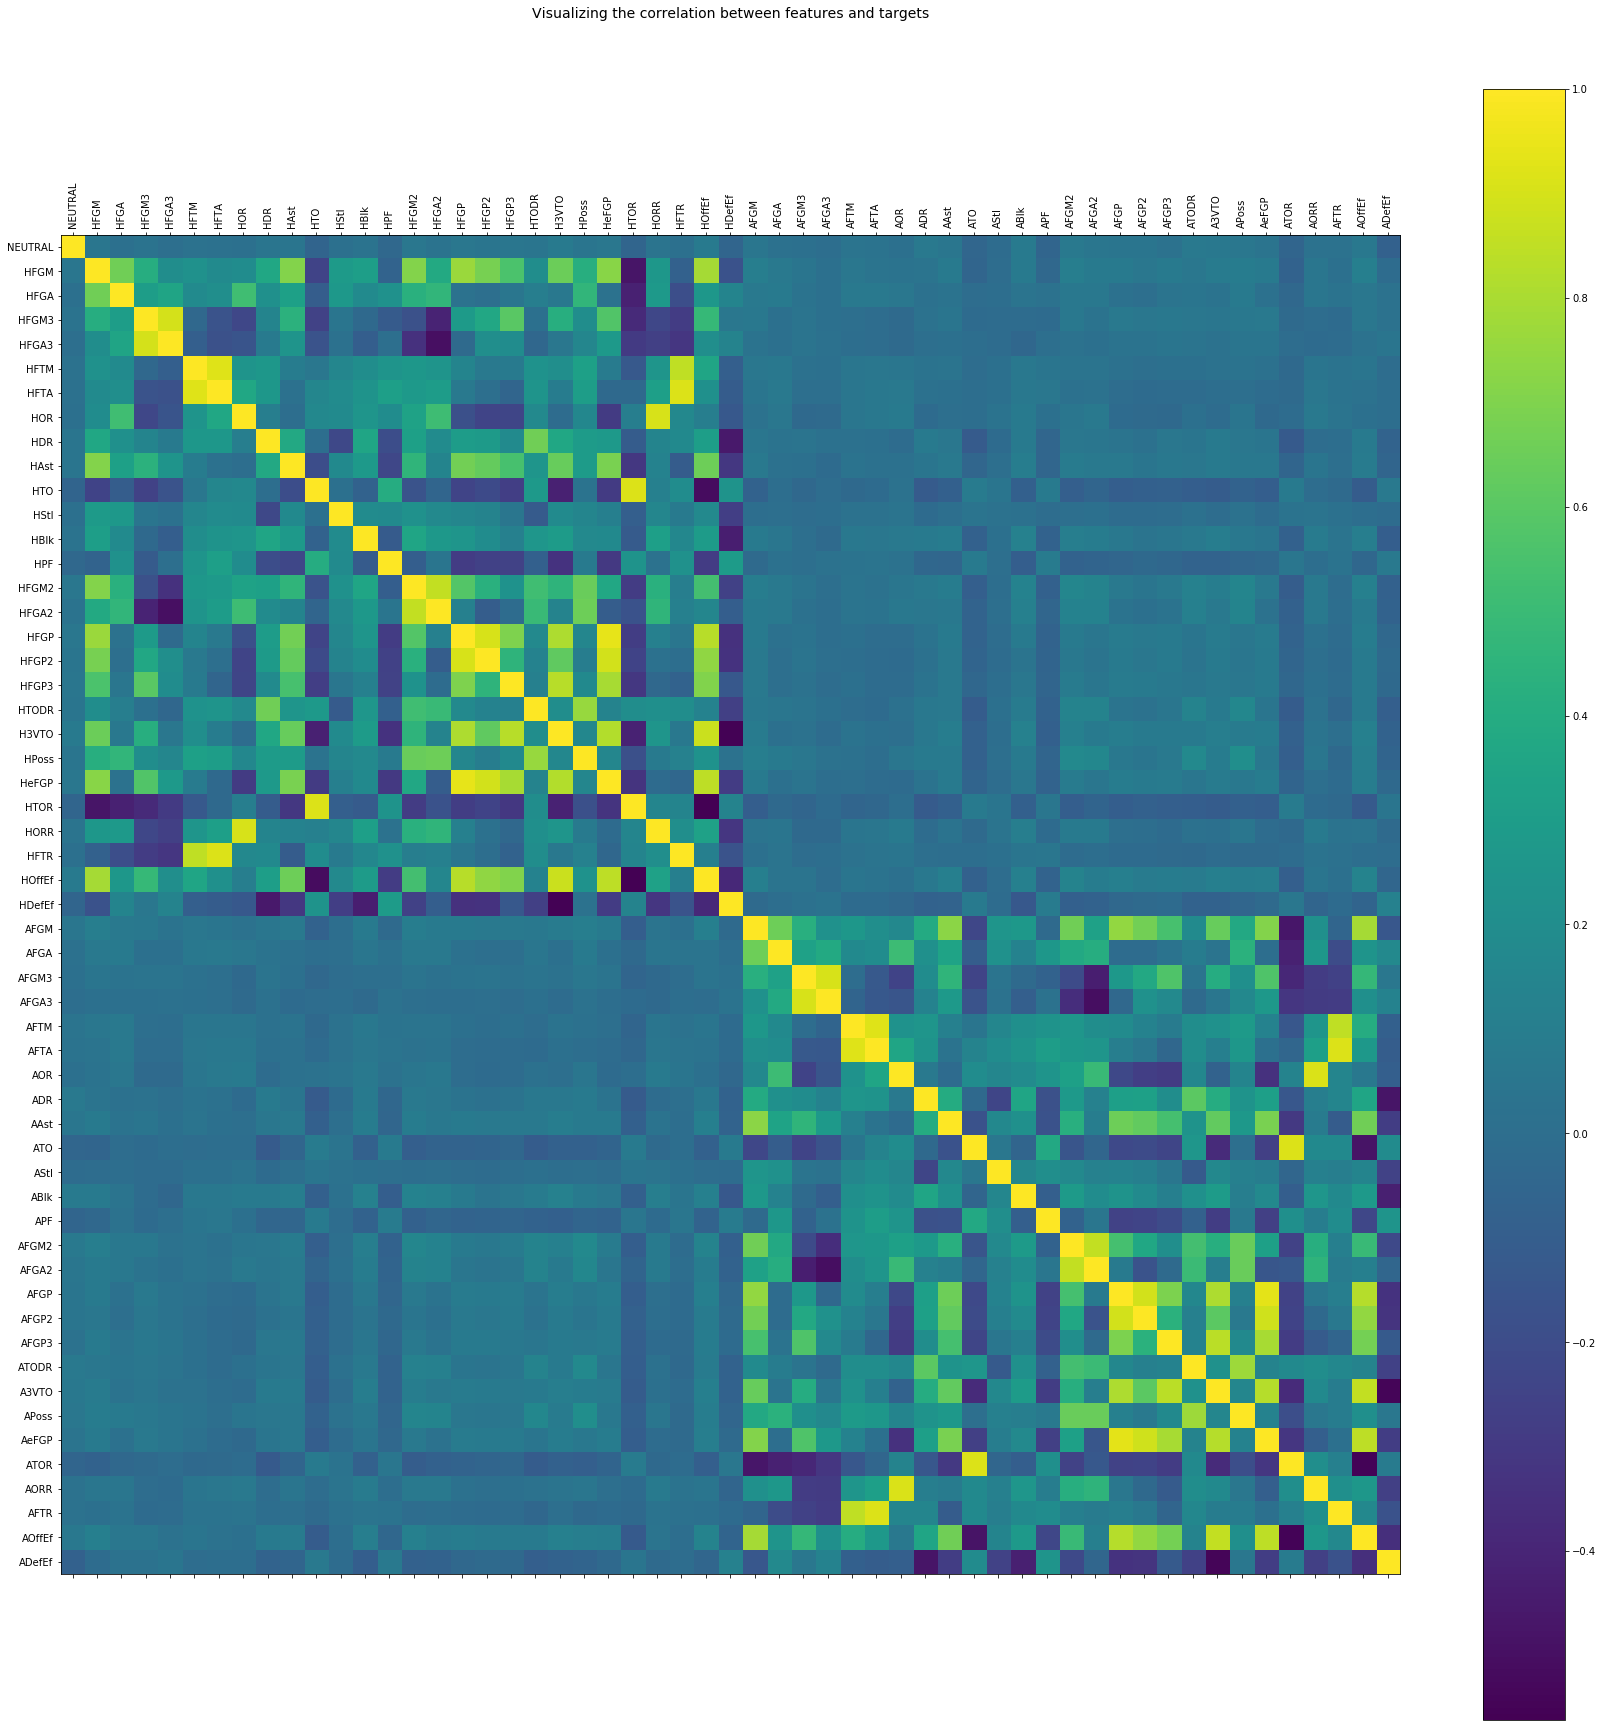

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)
ms = ax.matshow(X_train_corr_plot.corr())
fig.colorbar(ms)
label_count = list(range(len(X_train_corr_plot.columns)))
ax.set_xticks(label_count)
ax.set_xticklabels(X_train_corr_plot.columns, rotation=90)
ax.set_yticks(label_count)
ax.set_yticklabels(X_train_corr_plot.columns)
ax.set_title('Visualizing the correlation between features and targets', pad=150, fontsize=14);

## Feature Selection using : sklearn.feature_selection  Feature ranking with recursive feature elimination (RFE)

In [0]:
# Feature Selection using Logistic Regression model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True False False False False False False False  True False False False
  True False False False False False False  True  True  True False  True
 False False False False False False False False False False  True  True
 False False  True  True False False  True False  True False False False
  True False  True  True  True False  True  True False False False  True
 False False False]
[ 1  7 13  3 38 10 12 14  1 15  8  6  1  2 42 33 37 39 40  1  1  1 30  1
 34 31 44 27 32 26  9 43 35  5  1  1 11 29  1  1 16 28  1  4  1 17 20 41
  1 22  1  1  1 36  1  1 21 24 23  1 25 19 18]


In [0]:
# Feature Selection using DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
logreg = DecisionTreeRegressor(criterion="mse",min_samples_leaf=5)
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(X_train.columns)
print(rfe.support_)
print(rfe.ranking_)

Index(['NEUTRAL', 'HFGM', 'HFGA', 'HFGM3', 'HFGA3', 'HFTM', 'HFTA', 'HOR',
       'HDR', 'HAst', 'HTO', 'HStl', 'HBlk', 'HPF', 'HFGM2', 'HFGA2', 'HFGP',
       'HFGP2', 'HFGP3', 'HTORC', 'HDRR', 'HPFR', 'HTODR', 'HTODRR', 'H3VTO',
       'HPoss', 'HeFGP', 'HTOR', 'HORR', 'HFTR', 'HOffEf', 'HDefEf', 'AFGM',
       'AFGA', 'AFGM3', 'AFGA3', 'AFTM', 'AFTA', 'AOR', 'ADR', 'AAst', 'ATO',
       'AStl', 'ABlk', 'APF', 'AFGM2', 'AFGA2', 'AFGP', 'AFGP2', 'AFGP3',
       'ATORC', 'ADRR', 'APFR', 'ATODR', 'ATODRR', 'A3VTO', 'APoss', 'AeFGP',
       'ATOR', 'AORR', 'AFTR', 'AOffEf', 'ADefEf'],
      dtype='object')
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True  True False
 False  True  True  True  True  True  True  True  True False  True  True
  True  True False False False False False False  True  True False  True
  True  True  True]
[44

In [0]:
type(rfe.ranking_)

numpy.ndarray

## Based on the ranking on above feature selection logic using RFE - Pick top 10 ranked features.

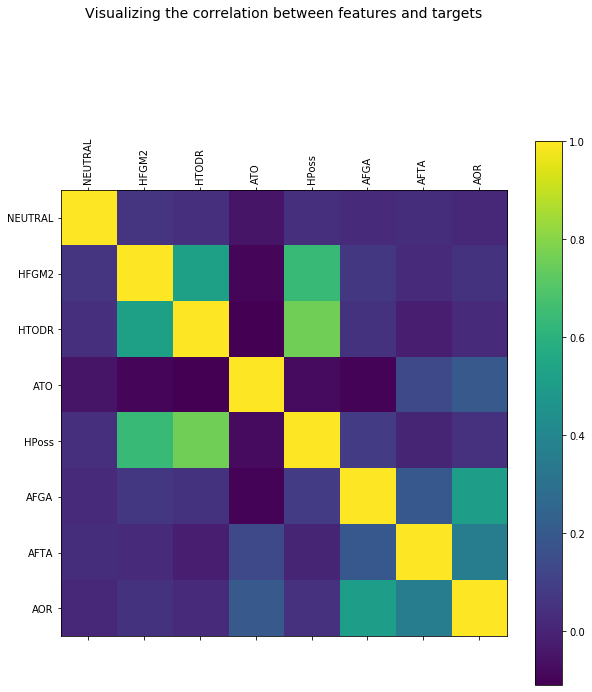

In [0]:
X_train_1 = X_train[['NEUTRAL','HFGM2','HTODR','ATO','HPoss','AFGA','AFTA','AOR']]
X_test_1 = X_test[['NEUTRAL','HFGM2','HTODR','ATO','HPoss','AFGA','AFTA','AOR']]


#Plot for top 10 ranked features: Visualizing the features correlation 
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ms = ax.matshow(X_train_1.corr())
fig.colorbar(ms)
label_count = list(range(len(X_train_1.columns)))
ax.set_xticks(label_count)
ax.set_xticklabels(X_train_1.columns, rotation=90)
ax.set_yticks(label_count)
ax.set_yticklabels(X_train_1.columns)
ax.set_title('Visualizing the correlation between features and targets', pad=150, fontsize=14);

In [0]:
m = ~(X_train.corr().mask(np.eye(len(X_train.corr()), dtype=bool)).abs() > 0.75).any()

pd.set_option('display.max_rows', 500)
print(m)

NEUTRAL     True
HFGM       False
HFGA        True
HFGM3      False
HFGA3      False
HFTM       False
HFTA       False
HOR        False
HDR         True
HAst        True
HTO        False
HStl        True
HBlk        True
HPF         True
HFGM2      False
HFGA2      False
HFGP       False
HFGP2      False
HFGP3      False
HTORC       True
HDRR        True
HPFR        True
HTODR      False
HTODRR      True
H3VTO      False
HPoss      False
HeFGP      False
HTOR       False
HORR       False
HFTR       False
HOffEf     False
HDefEf      True
AFGM       False
AFGA        True
AFGM3      False
AFGA3      False
AFTM       False
AFTA       False
AOR        False
ADR         True
AAst        True
ATO        False
AStl        True
ABlk        True
APF         True
AFGM2      False
AFGA2      False
AFGP       False
AFGP2      False
AFGP3      False
ATORC       True
ADRR        True
APFR        True
ATODR      False
ATODRR      True
A3VTO      False
APoss      False
AeFGP      False
ATOR       Fal

## Analysing Feature with high correlation [ corr greater that 0.75] 

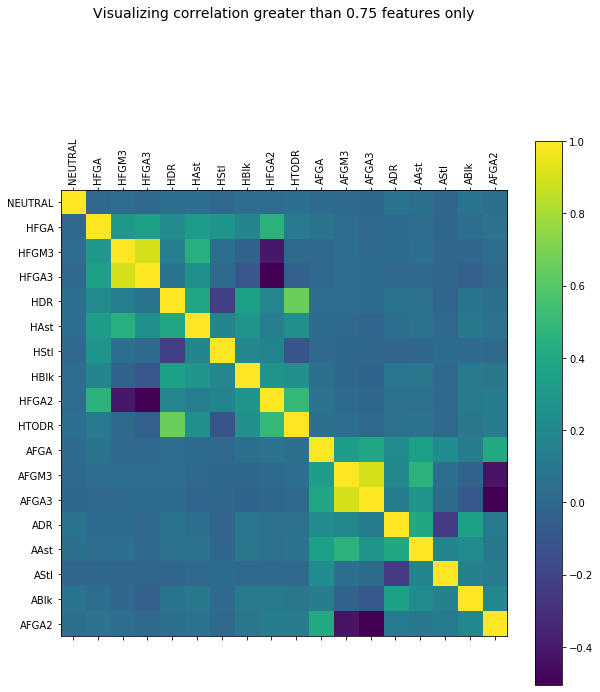

In [0]:
# Features with more than 0.75 correlation.
#'NEUTRAL',HFGA',HFGM3',HFGA3',HDR',HAst',HStl',HBlk',HFGA2',HTODR',AFGA',AFGM3',AFGA3',ADR',AAst',AStl',ABlk',AFGA2'

X_train_1 = X_train[['NEUTRAL','HFGA','HFGM3','HFGA3','HDR','HAst','HStl','HBlk','HFGA2','HTODR','AFGA','AFGM3','AFGA3','ADR','AAst','AStl','ABlk','AFGA2']]
X_test_1 = X_test[['NEUTRAL','HFGA','HFGM3','HFGA3','HDR','HAst','HStl','HBlk','HFGA2','HTODR','AFGA','AFGM3','AFGA3','ADR','AAst','AStl','ABlk','AFGA2']]


#Plot for top 10 ranked features: Visualizing the features correlation 
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ms = ax.matshow(X_train_1.corr())
fig.colorbar(ms)
label_count = list(range(len(X_train_1.columns)))
ax.set_xticks(label_count)
ax.set_xticklabels(X_train_1.columns, rotation=90)
ax.set_yticks(label_count)
ax.set_yticklabels(X_train_1.columns)
ax.set_title('Visualizing correlation greater than 0.75 features only', pad=150, fontsize=14);

## Selecting select_kbest_reg features using f_regression

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression

# SCORE  linear regression input variables using correlation producing F scores and corresponding p-values
# K is used select top k rated input features
def select_kbest_reg(data_frame, target, k=5):
    """
    Selecting K-Best features regression
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_regression, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores


print(X_train.columns)

X_train.head()

df = pd.DataFrame(X_train, columns=X_train.columns).copy()
df["MEDV"] = y_train

per_feat = select_kbest_reg(df, 'MEDV', k=10)
per_feat_sorted = per_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
top_k_feature_indices = per_feat_sorted['Attribute'].values.flatten()
print("\n Feature Score for a linear regression using correlation\n")
print(per_feat_sorted)   ##INDUS, RM, TAX, PTRATIO, LSAT

print(np.linalg.norm(y_train))

Index(['NEUTRAL', 'HFGM', 'HFGA', 'HFGM3', 'HFGA3', 'HFTM', 'HFTA', 'HOR',
       'HDR', 'HAst', 'HTO', 'HStl', 'HBlk', 'HPF', 'HFGM2', 'HFGA2', 'HFGP',
       'HFGP2', 'HFGP3', 'HTORC', 'HDRR', 'HPFR', 'HTODR', 'HTODRR', 'H3VTO',
       'HPoss', 'HeFGP', 'HTOR', 'HORR', 'HFTR', 'HOffEf', 'HDefEf', 'AFGM',
       'AFGA', 'AFGM3', 'AFGA3', 'AFTM', 'AFTA', 'AOR', 'ADR', 'AAst', 'ATO',
       'AStl', 'ABlk', 'APF', 'AFGM2', 'AFGA2', 'AFGP', 'AFGP2', 'AFGP3',
       'ATORC', 'ADRR', 'APFR', 'ATODR', 'ATODRR', 'A3VTO', 'APoss', 'AeFGP',
       'ATOR', 'AORR', 'AFTR', 'AOffEf', 'ADefEf'],
      dtype='object')

 Feature Score for a linear regression using correlation

       F Score       P Value  Support Attribute
30  423.968368  6.838435e-90     True    HOffEf
24  404.496613  4.993321e-86     True     H3VTO
55  398.591204  7.470763e-85     True     A3VTO
61  362.111899  1.464352e-77     True    AOffEf
31  348.944869  6.491618e-75     True    HDefEf
62  339.101565  6.252832e-73     True    

## Feature - Plot coeffients of the learnt linear regression model  - Scoring coefficients - analysis

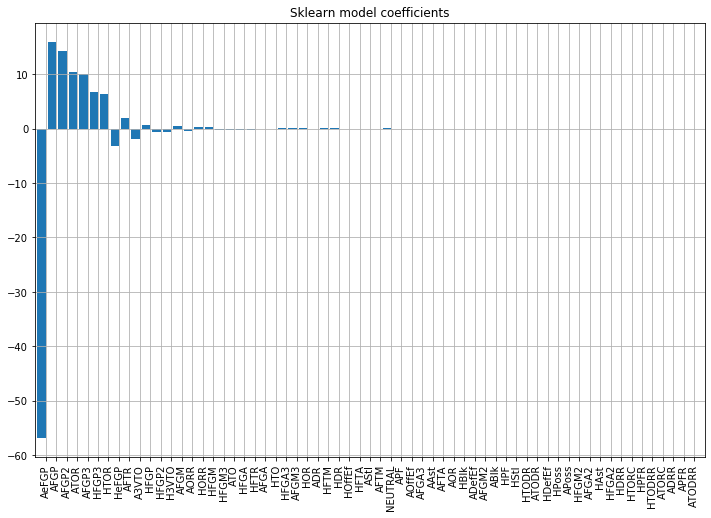

In [0]:
model_sk = LinearRegression()
model_sk.fit(X_train, y_train)

feat_scores = pd.DataFrame()
feat_scores["coefficient"] = model_sk.coef_
feat_scores["ABScoefficient"] = np.abs(model_sk.coef_)
feat_scores["Attribute"] = X_train.columns
feat_scores = feat_scores.sort_values(["ABScoefficient"], ascending=[False])
feat_scores

plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_sk.coef_.shape[0]) - 0.4, feat_scores["coefficient"] )
plt.xticks(np.arange(model_sk.coef_.shape[0]), feat_scores["Attribute"], rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.grid()
plt.title("Sklearn model coefficients");

## Feature importance using forest.feature_importances_

 1) APF                            0.047671
 2) AORR                           0.043563
 3) ABlk                           0.041270
 4) AFGP3                          0.040320
 5) AOR                            0.040261
 6) AOffEf                         0.039624
 7) ATODR                          0.039537
 8) APoss                          0.038500
 9) AeFGP                          0.038319
10) AStl                           0.037690
11) ADR                            0.036208
12) ADefEf                         0.035677
13) ATOR                           0.035555
14) AFGM2                          0.035147
15) AFTM                           0.034895
16) ATO                            0.034657
17) AFGP2                          0.033653
18) AFGM3                          0.033627
19) AFGP                           0.033474
20) AFGA2                          0.032758
21) AFTR                           0.032485
22) AFGA3                          0.032462
23) AAst                        

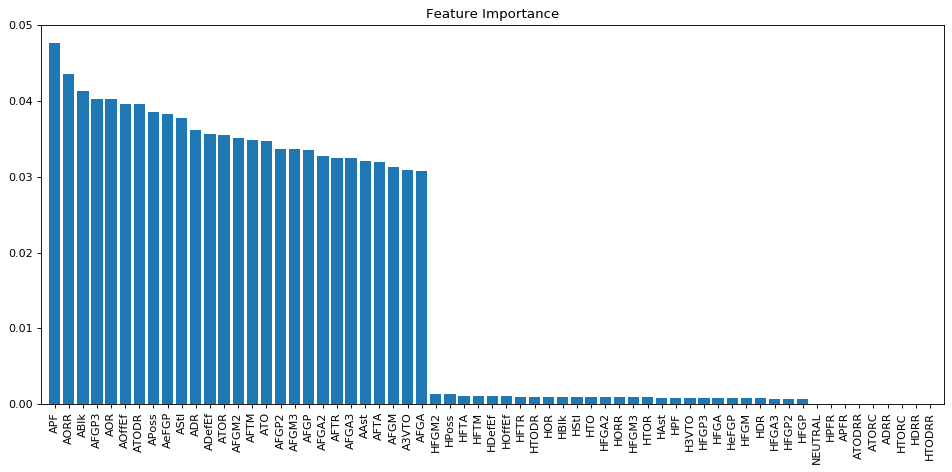

In [0]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = X_train.columns

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
plt.figure(figsize=(12, 6), dpi=80)
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

In [0]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of samples that meet this criterion:', 
      X_selected.shape[0])

for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

Number of samples that meet this criterion: 4270


## Feature Selection : Sequential feature selection algorithms: Sequential Backward Selection : SBS(knn, k_features=1)

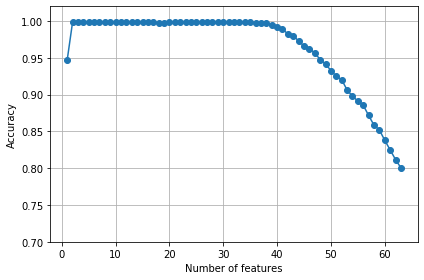

In [45]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    
    
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [0]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

lr = LogisticRegression(C= 10, penalty= 'l2')

# selecting features
sbs = SBS(lr, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.4, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

# Pipelines

All of our data was numerical, so our use of a pipeline was straightforward
we used a MinMaxScaler to standardize the data, and used a classifier for the method.
We also used a parameter grid for the penalty and C values, and then put it into a grid.
We have run this dozens of times in order to evaluate our features, but in this first phase we have
not experimented with other types of methods -- we will explore those in future runs.
We will show a few illustrative runs below.

## Pipeline - grid search using logistic regression model

In [0]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


pipe_model = Pipeline([('scaler', MinMaxScaler()),
                  ('classifier', LogisticRegression())])

 #Classifier Pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier())
])
# Params for classifier
params = {"classifier__max_depth": [2, None],
              "classifier__max_features": [5,10],
             # "classifier__min_samples_split": [1, 3, 10],
             # "classifier__min_samples_leaf": [0, 0.5],
              # "bootstrap": [True, False],
              "classifier__criterion": ["gini", "entropy"]}

# Grid Search Execute
rf_grid = GridSearchCV(estimator=pipeline , param_grid=params) #cv=10
rf_detector = rf_grid.fit(X_train, y_train)
print(rf_grid.cv_results_)


preds_train = rf_grid.best_estimator_.predict(X_train)
preds_test= rf_grid.best_estimator_.predict(X_test)
print("best params    ",rf_grid.best_params_)
print("best_estimator_   ",rf_grid.best_estimator_)

In [0]:
results = pd.DataFrame(columns=["Accuracy"])

#zero_coef = rf_grid.best_estimator_.named_steps['classifier'].coef_.size - np.count_nonzero(rf_grid.best_estimator_.named_steps['classifier'].coef_)
results = results.append(pd.DataFrame(
        [[np.round(accuracy_score(y_train, preds_train), 3)],[np.round(accuracy_score(y_test, preds_test), 3)]], 
        columns=["Accuracy"],
        index=["Sklearn-LR-L1-C1 Train-Mod", "Sklearn-LR-L1-C1 Test-Mod"]))
results

## CHECKING USING ESTIMATOR - LogisticRegression(), RandomForestClassifier(), GaussianNB()

In [0]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_idx = list(cv.split(X_train, y_train))

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from time import time


acc = None
cm = None
estimator = [LogisticRegression(), RandomForestClassifier(), GaussianNB()]

finalAccuracy = 0

for e in estimator:
    for train_idx, test_idx in cv_idx:

        # split
        #X_train, X_test = Results2017.values[train_idx], Results2017.values[test_idx]
        #y_train, y_test = y[train_idx], y[test_idx]

        # create logistic regression pipeline
        model = Pipeline([('scaler', MinMaxScaler()),
                          ('classifier', e)])
        
        t0 = time()
        model.fit(X_train, y_train)
        print("done in %0.3fs" % (time() - t0))
        y_pred = model.predict(X_test)

        # evaluate
        
        tempAccuracy = np.round(accuracy_score(y_test, y_pred), 3)
        if tempAccuracy > finalAccuracy :
            finalAccuracy = tempAccuracy

        print("Train accuracy :", np.round(accuracy_score(y_train, preds_train), 3))
        print("Test accuracy :", np.round(accuracy_score(y_test, y_pred), 3))
        
        

print ("finalAccuracy  :: " , finalAccuracy)


In [0]:
pd.set_option('display.max_colwidth', -1)
runResults = pd.DataFrame(columns=['Model_Description', 'Bagging', 'accuracy_score'])
runResults.loc[0] = ['LogisticRegression/RandomForestClassifier/GaussianNB', 'Estimator', finalAccuracy ]

In [0]:
runResults

## Bagging - Using DecisionTreeClassifier - Calculate Accuracy

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


print(accuracy_score(y_test, y_pred))

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

print("BaggingClassifier - DecisionTreeClassifier accuracy_score :: " , accuracy_score(y_test, y_pred))

runResults.loc[1] = ['DecisionTreeClassifier', 'No', accuracy_score(y_test, y_pred_tree)]
runResults.loc[2] = ['BaggingClassifier - DecisionTreeClassifier', 'Yes', accuracy_score(y_test, y_pred)]

In [0]:
runResults

## Bagging - Using Logistic Regression - Calculate Accuracy.

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

bag_clf = BaggingClassifier(
    LogisticRegression(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


print(accuracy_score(y_test, y_pred))


clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

In [0]:
runResults.loc[3] = ['LogisticRegression', 'No', accuracy_score(y_test, y_pred_tree)]
runResults.loc[4] = ['BaggingClassifier - LogisticRegression', 'Yes', accuracy_score(y_test, y_pred) ]
runResults

## Bagging using sklearn.neighbors.NearestNeighbors

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

bag_clf = BaggingClassifier(KNeighborsClassifier(n_neighbors=5), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)


print("BaggingClassifier - KNeighborsClassifier accuracy_score :: " , accuracy_score(y_test, y_pred))

clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print("KNeighborsClassifier accuracy_score :: " , accuracy_score(y_test, y_pred_tree))


runResults.loc[5] = ['KNeighborsClassifier', 'No', accuracy_score(y_test, y_pred_tree)]
runResults.loc[6] = ['BaggingClassifier - KNeighborsClassifier', 'Yes', accuracy_score(y_test, y_pred) ]
runResults

## Bagging using from sklearn.ensemble import RandomForestClassifier

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

bag_clf = BaggingClassifier(pipeline, n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


print("BaggingClassifier - RandomForestClassifier accuracy_score :: " , accuracy_score(y_test, y_pred))

clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print("RandomForestClassifier accuracy_score :: " , accuracy_score(y_test, y_pred_tree))


runResults.loc[7] = ['RandomForestClassifier-StandardScaler', 'No', accuracy_score(y_test, y_pred_tree)]
runResults.loc[8] = ['BaggingClassifier - RandomForest-StandardScaler', 'Yes', accuracy_score(y_test, y_pred)]
runResults

## Bagging using from sklearn.ensemble import RandomForestClassifier - MinMaxScaler

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),    
    ('classifier', RandomForestClassifier())
])

bag_clf = BaggingClassifier(pipeline, n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


print("BaggingClassifier - RandomForestClassifier accuracy_score :: " , accuracy_score(y_test, y_pred))

clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print("RandomForestClassifier accuracy_score :: " , accuracy_score(y_test, y_pred_tree))


runResults.loc[9] = ['RandomForestClassifier-MinMaxScaler', 'No', accuracy_score(y_test, y_pred_tree)]
runResults.loc[10] = ['BaggingClassifier - RandomForest-MinMaxScaler', 'Yes', accuracy_score(y_test, y_pred) ]
runResults

## Bagging using from sklearn.ensemble import SVM - StandardScaler

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

pipeline = Pipeline([
    ('scaler', StandardScaler()),    
    ('classifier', SVC())
])

bag_clf = BaggingClassifier(pipeline, n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


print("BaggingClassifier - SVC accuracy_score :: " , accuracy_score(y_test, y_pred))

clf = SVC()
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print("SVC accuracy_score :: " , accuracy_score(y_test, y_pred_tree))


runResults.loc[11] = ['SVC-StdScaler', 'No', accuracy_score(y_test, y_pred_tree)]
runResults.loc[12] = ['BaggingClassifier - SVC-StdMaxScaler', 'Yes', accuracy_score(y_test, y_pred)]
runResults

## Bagging using from sklearn.ensemble import SVM - MinMaxScaler

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),    
    ('classifier', SVC())
])

bag_clf = BaggingClassifier(pipeline, n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


print("BaggingClassifier - SVC accuracy_score :: " , accuracy_score(y_test, y_pred))

clf = SVC()
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print("SVC accuracy_score :: " , accuracy_score(y_test, y_pred_tree))

runResults.loc[13] = ['SVC-MinMaxScaler', 'No', accuracy_score(y_test, y_pred_tree)]
runResults.loc[14] = ['BaggingClassifier - SVC-MinMaxScaler', 'Yes', accuracy_score(y_test, y_pred) ]
runResults

## Bagging using from sklearn.ensemble import SGDClassifier

### SGDClassifier(loss="modified_huber", shuffle=True))

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

pipeline = Pipeline([
    ('scaler', StandardScaler()),    
    ('classifier', SGDClassifier(loss="modified_huber", shuffle=True))
])

bag_clf = BaggingClassifier(pipeline, n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


print("BaggingClassifier - SGDClassifier accuracy_score :: " , accuracy_score(y_test, y_pred))

clf = SGDClassifier(loss="modified_huber", shuffle=True)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print("SGDClassifier accuracy_score :: " , accuracy_score(y_test, y_pred_tree))


runResults.loc[15] = ['SGDClassifier-StandardScaler', 'No', accuracy_score(y_test, y_pred_tree)]
runResults.loc[16] = ['BaggingClassifier - SGDClassifier-StandardScaler', 'Yes', accuracy_score(y_test, y_pred) ]
runResults

### SGDClassifier(loss="log", shuffle=True)

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

pipeline = Pipeline([
    ('scaler', StandardScaler()),    
    ('classifier', SGDClassifier(loss="log", shuffle=True))
])

bag_clf = BaggingClassifier(pipeline, n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


print("BaggingClassifier - SGDClassifier accuracy_score :: " , accuracy_score(y_test, y_pred))

clf = SGDClassifier(loss="log", shuffle=True)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print("SGDClassifier accuracy_score :: " , accuracy_score(y_test, y_pred_tree))

runResults.loc[17] = ['SGDClassifier-StandardScaler-log', 'No', accuracy_score(y_test, y_pred_tree)]
runResults.loc[18] = ['BaggingClassifier - SGDClassifier-StandardScaler-log', 'Yes', accuracy_score(y_test, y_pred)]
runResults

### SGDClassifier(loss="hinge", shuffle=True)

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

pipeline = Pipeline([
    ('scaler', StandardScaler()),    
    ('classifier', SGDClassifier(loss="hinge", shuffle=True))
])

bag_clf = BaggingClassifier(pipeline, n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


print("BaggingClassifier - SGDClassifier accuracy_score :: " , accuracy_score(y_test, y_pred))

clf = SGDClassifier(loss="hinge", shuffle=True)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print("SGDClassifier accuracy_score :: " , accuracy_score(y_test, y_pred_tree))

runResults.loc[19] = ['SGDClassifier-StandardScaler-hinge', 'No', accuracy_score(y_test, y_pred_tree)]
runResults.loc[20] = ['BaggingClassifier - SGDClassifier-StandardScaler-hinge', 'Yes', accuracy_score(y_test, y_pred)]
runResults

## Bagging using from GaussianNB

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

pipeline = Pipeline([
    ('scaler', StandardScaler()),    
    ('classifier', GaussianNB())
])

bag_clf = BaggingClassifier(pipeline, n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


print("BaggingClassifier - GaussianNB accuracy_score :: " , accuracy_score(y_test, y_pred))

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print("GaussianNB accuracy_score :: " , accuracy_score(y_test, y_pred_tree))


runResults.loc[21] = ['GaussianNB-StandardScaler', 'No', accuracy_score(y_test, y_pred_tree)]
runResults.loc[22] = ['BaggingClassifier - GaussianNB-StandardScaler', 'Yes', accuracy_score(y_test, y_pred) ]
runResults

## Bagging using from LogisticRegression

In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),    
    ('classifier', LogisticRegression())
])

bag_clf = BaggingClassifier(pipeline, n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


print("BaggingClassifier - LogisticRegression accuracy_score :: " , accuracy_score(y_test, y_pred))

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print("LogisticRegression accuracy_score :: " , accuracy_score(y_test, y_pred_tree))

## SUMMARY:

We tried following different models and calculated accuracy for each model using various parameters/pipeline process/Bagging approaches etc

    1. SVC
    2. LogisticRegression
    3. SGDClassifier
    4. GaussianNB
    5. RandomForestClassifier
    6. KNeighborsClassifier
    7. DecisionTreeClassifier

The next section contains our best model

# Best Model

In [0]:
#DecisionTreeClassifier
pipe_model = Pipeline([('scaler', StandardScaler()),
                  ('classifier', DecisionTreeClassifier())])

param_grid = {'classifier__max_depth': [2],#, 4, 6, 8, 10],
                  'classifier__max_features': [63] }

gs = GridSearchCV(pipe_model, param_grid, cv=5, verbose=1)

In [0]:
# fit and run predictions
pipe_model.named_steps['classifier']
gs.fit(X_train, y_train)

preds_train = gs.best_estimator_.predict(X_train)
preds_test = gs.best_estimator_.predict(X_test)

print("best params    ",gs.best_params_)

In [0]:
print("Train accuracy:", np.round(accuracy_score(y_train, preds_train), 3))
print("Test accuracy:", np.round(accuracy_score(y_test, preds_test), 3))

cm_train = confusion_matrix(y_train, preds_train).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]

cm_test = confusion_matrix(y_test, preds_test).astype(np.float32)
cm_test /= cm_test.sum(axis=1)[:, np.newaxis]

print(confusion_matrix(y_train, preds_train).astype(np.float32))
print(confusion_matrix(y_test, preds_test).astype(np.float32))

#np.unique(preds_test, return_counts=True)

np.unique(y_test, return_counts=True)

In [0]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
g = sns.heatmap(cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
#g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train", fontsize=14)

plt.subplot(122)
g = sns.heatmap(cm_test, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
#g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test", fontsize=14);

# Experimental Results Table

In [0]:
runResults.loc[23] = ['Grid Search DecisionTreeClassifier Estimator -StandardScaler', 'Yes', accuracy_score(y_test, preds_test) ]
runResults

# Statistical Significance Test

We compared a vanilla Logistic Regression model with the best model from our Grid Search

In [0]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# A sampling based bakeoff using *K-fold cross-validation*: 
# it randomly splits the training set into K distinct subsets (k=30)
# this bakeoff framework can be used for regression or classification
#Control system is a linear regression based pipeline

kFolds=30

#X_train_processed = MinMaxScaler(X_train)
#X_train_processed = StandardScaler(X_train)
X_train_processed = X_train


log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train_processed, y_train,
                             scoring="accuracy", cv=kFolds)

#lin_reg = LinearRegression()
#lin_scores = cross_val_score(lin_reg, X_train_processed, y_train,
#                             scoring="accuracy", cv=kFolds)

control = log_scores
#control = lin_scores
display_scores(control)

#Treatment system is a replica of our grid search model
#gs_model = DecisionTreeClassifier(max_depth = 2, max_features = 63)
scores = cross_val_score(pipe_model, X_train_processed, y_train,
                         scoring="accuracy", cv=kFolds)


treatment = scores
display_scores(treatment)

#paired t-test; two-tailed p-value (aka two-sided)
(t_score, p_value) = stats.ttest_rel(control, treatment)
print("The p-value is %0.5f for a t-score of %0.5f." %(p_value, t_score))
#"The p-value is 0.00019 for a t-score of -4.28218." 
if p_value > 0.05/2:  #Two sided 
    print('There is no significant difference between the two machine learning pipelines (Accept H0)')
else:
    print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
    if t_score < 0.0:
        print('Machine learning pipeline A is better than B')
    else:
        print('Machine learning pipeline B is better than A')

In [0]:
# do basic histograms
plt.title('Train / test data')
plt.hist(y_train, label='Train')
plt.hist(y_test, label='Test')
plt.legend(loc='best')
plt.show()

In [0]:
# marker PCA, use whole X with diff color for train and test
from sklearn.decomposition import PCA
X1 = np.concatenate((X_train, X_test))
pca = PCA(n_components=2)
p = pca.fit(X1).fit_transform(X1)
Ntrain=X_train.shape[0]
plt.title('PCA decomposition')
plt.scatter(p[0:Ntrain,0], p[0:Ntrain,1], label='Train')
plt.scatter(p[Ntrain:,0], p[Ntrain:,1], label='Test', color='orange')
plt.legend(loc='best')
plt.show()

# Deep Learning Model

In [0]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [0]:
X_train = X_train.loc[:,['NEUTRAL', 'HeFGP', 'HTOR', 'HORR', 'HFTR', 'HOffEf', 'HDefEf',
       'AeFGP', 'ATOR', 'AORR', 'AFTR', 'AOffEf', 'ADefEf']]

X_test = X_test.loc[:,['NEUTRAL', 'HeFGP', 'HTOR', 'HORR', 'HFTR', 'HOffEf', 'HDefEf',
       'AeFGP', 'ATOR', 'AORR', 'AFTR', 'AOffEf', 'ADefEf']]

In [0]:
X = [X_train, X_test]
X = pd.concat(X)
y = [y_train, y_test]
y = pd.concat(y)

## DL - BASE MODEL - Nueral Network - Mean Square Errror loss function

In [0]:
from keras.models import Sequential 
from keras.layers import Dense, Activation

In [0]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [0]:
model = baseline_model()
model.fit(X_train, y_train, epochs=100, batch_size=100, verbose=0)

In [0]:
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

In [0]:
print("Train accuracy:", np.round(accuracy_score(y_train, preds_train.round()), 3))
print("Test accuracy:", np.round(accuracy_score(y_test, preds_test.round()), 3))

In [0]:
runResults.loc[24] = ['DEEP LEARNING BASE model', 'No', accuracy_score(y_test, preds_test) ]


## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy - adam optimizer - sigmoid  WITHOUT STANDARD SCALAR

In [0]:
## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy - adam optimizer - sigmoid  WITHOUT STANDARD SCALAR

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
model.fit(X_train,y_train, epochs=100, batch_size=80, validation_split = 0.2)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

print("Train accuracy:", np.round(accuracy_score(y_train, preds_train.round()), 3))
print("Test accuracy:", np.round(accuracy_score(y_test, preds_test.round()), 3))


In [0]:
runResults.loc[24] = ['DEEP LEARNING BASE model Without standardization', 'No', accuracy_score(y_test, preds_test) ]


## Re-Run The Baseline Model With Data Preparation - TUNING - StandardScaler

In [0]:
## DL - Base Model with fit, evaluate and plat matrix - binary_crossentropy - adam optimizer - sigmoid - Standard Scalar



from keras.layers.advanced_activations import PReLU

scale = StandardScaler(with_mean=0, with_std=1)
new_X_train = scale.fit_transform(X_train)
new_X_test = scale.transform(X_test)

model = Sequential()

model.add(Dense(13, input_dim=13, kernel_initializer="normal"))
model.add(PReLU(alpha_initializer='zero', weights=None))

model.add(Dense(1, kernel_initializer='normal'))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(new_X_train, y_train, epochs=1000, batch_size=len(X_train), validation_split=0.15, verbose=0)

scores = model.evaluate(new_X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

preds_train1 = model.predict(new_X_train)
preds_test1 = model.predict(new_X_test)
print("Train accuracy:", np.round(accuracy_score(y_train, preds_train1.round()), 3))
print("Test accuracy:", np.round(accuracy_score(y_test, preds_test1.round()), 3))



In [0]:
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## DL - Base model with binary binary_crossentropy - ESTIMATOR IMPLEMENTATION AND KFOLD

In [0]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

    
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

param_grid = {'classifier__max_depth': [2, 4, 6, 8, 10],
                  'classifier__max_features': [13]
                      #[5, 11, 17, 19]
                      #[12,24,36,48,60]#
                      #[9, 11, 12, 13]
                      #[10, 20, 28, 33]
                  }

gs = GridSearchCV(estimator, param_grid, cv=5, verbose=1)

pipe_model.named_steps['classifier']
gs.fit(X_train, y_train)

preds_train = gs.best_estimator_.predict(X_train)
preds_test = gs.best_estimator_.predict(X_test)

print("best params    ",gs.best_params_)

In [0]:
runResults.loc[25] = ['DEEP LEARNING BASE model - ESTIMAROT AND KFOLD IMPL', 'No', accuracy_score(y_test, preds_test) ]


## Model with Grid Search - KerasClassifier - binary_crossentropy - adam - activation [sigmoid. relu]

In [0]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
model.fit(X_train,y_train)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
#grid_result = grid.fit(X, Y)
grid_result = grid.fit(X_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

pred = grid.predict(X_test)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

print("Train accuracy:", np.round(accuracy_score(y_train, preds_train.round()), 3))
print("Test accuracy:", np.round(accuracy_score(y_test, preds_test.round()), 3))


In [0]:
runResults.loc[26] = ['DEEP LEARNING BASE model - GRID SEARCH BEST PARAM IMPL', 'No', accuracy_score(y_test, preds_test) ]

##Model KerasClassifier - binary_crossentropy - adam - activation [sigmoid. relu] - **Root mean square optimizer**

In [0]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(13, activation='relu', input_dim=13))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

    return model
# fix random seed for reproducibility
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
model.fit(X_train,y_train, epochs=100, batch_size=80, validation_split = 0.2)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

print("Train accuracy:", np.round(accuracy_score(y_train, preds_train.round()), 3))
print("Test accuracy:", np.round(accuracy_score(y_test, preds_test.round()), 3))


In [0]:
runResults.loc[27] = ['DEEP LEARNING BASE model - ROOT MEAN SQUARE OPTIMIZER', 'No', accuracy_score(y_test, preds_test) ]

##Model with Grid Search - KerasClassifier - binary_crossentropy - adam - activation [sigmoid. relu] - **Stochastic gradient descent (SGD)**

In [0]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(13, activation='relu', input_dim=13))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy'])

    return model
# fix random seed for reproducibility
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
model.fit(X_train,y_train, epochs=100, batch_size=80, validation_split = 0.2)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

print("Train accuracy:", np.round(accuracy_score(y_train, preds_train.round()), 3))
print("Test accuracy:", np.round(accuracy_score(y_test, preds_test.round()), 3))


In [0]:
runResults.loc[28] = ['DEEP LEARNING BASE model - Stochastic gradient descent (SGD) OPTIMIZER', 'No', accuracy_score(y_test, preds_test) ]

In [0]:
runResults

# Discussion/Analysis of Results

We used 31 features for both the home and away teams, plus an indicator for whether the game was played on a neutral court. That equals 63 features available for the model. We expiremented extensively with different combinations of numbers of features, (using all 63, using only raw data, using only features we created), different ways we aggregated the data, (actual game stats, averages, home and away averages, differences in stats between the 2 teams) and with different models, (logistic regression, decisiontreeClassifier, xgboost, etc.). In the end, or best model, which was statistically significant compared to a vanilla logistic regression model, was using the average from the first 80% games of all 63 features for the matchups for both the train and test datasets. It got us to 63.7% accuracy which was better than only picking based on the home team, but was a little short of our goal of 68%.

We played around a little with deep learning models, but were unable to produce a significant result.